## Access Kaggle
Serveral things you need to do to access Kaggle
- Sign in to Kaggle and join the competition called **BCI Homework 3 Kaggle Judge** (using the link we provide in the document)

- Create your own kaggle API token (in your account->API)
  
  <img src="https://i.imgur.com/Gia6TwE.png" alt="drawing" width="800"/>
- Upload API token (.json file) to Colab 

   <img src="https://i.imgur.com/xjEXBYs.png" alt="drawing" width="200"/>

In [1]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions list

ref                                                                                deadline             category             reward  teamCount  userHasEntered  
---------------------------------------------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection               2023-06-14 23:59:00  Featured         $1,000,000        739           False  
https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction      2023-06-08 23:59:00  Research           $100,000        818           False  
https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction  2023-05-18 23:59:00  Featured            $60,000       1586           False  
https://www.kaggle.com/competitions/predict-student-performance-from-game-play     2023-06-14 23:59:00  Featured            $55,000        984           False  
https://www.kaggle.com/competition

## Download Dataset from Kaggle

In [2]:
!kaggle competitions download -c bci-homework-3-kaggle-judge
!unzip -qq bci-homework-3-kaggle-judge.zip -d ./
!ls -l BCI_hw3_dataset

 99% 279M/282M [00:09<00:00, 38.4MB/s]
100% 282M/282M [00:09<00:00, 31.3MB/s]
total 16
-rw-r--r-- 1 root root  269 Apr 12 08:33 data_detail.json
drwxr-xr-x 2 root root 4096 May  4 19:40 labeled_test
drwxr-xr-x 2 root root 4096 May  4 19:40 train
drwxr-xr-x 2 root root 4096 May  4 19:40 unlabeled_test


## Install Package (Optional)

In [3]:
!pip install torchinfo
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.1 MB/s eta 0:00:00


## Import Package and Library to Python Session

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F

from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import math
import time
import csv
import mne
import sys
import os

DATASET_DIR = "BCI_hw3_dataset/train"
DATASET_DIR_TEST = "BCI_hw3_dataset/labeled_test"
DATASET_DIR_EXAM = "BCI_hw3_dataset/unlabeled_test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## EEG Model

### EEGNet

In [5]:
class EEGNet(nn.Module):
    """EEGNet model from Lawhern et al 2018.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    kernLength: int
        Length of temporal convolution in first layer.
    F1, F2: int
        Number of temporal filters (F1) and number of pointwise filters (F2) to learn.
    D: int
        Number of spatial filters to learn within each temporal convolution.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1611.08024
    """
    def __init__(self, C, N, nb_classes, kernLength=64, F1=8, F2=16, D=2, dropoutRate=0.5):
        super(EEGNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding="valid", bias=False),
            nn.BatchNorm2d(F1, eps=1e-3, momentum=0.99)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                F1, D * F1, (C, 1), groups=F1, bias=False
            ),
            nn.BatchNorm2d(D * F1, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                D * F1, D * F1, (1, 16),
                padding=(0, 8), groups=D * F1, bias=False
            ),
            nn.Conv2d(D * F1, F2, (1, 1), bias=False),
            nn.BatchNorm2d(F2, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )

        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### ShallowConvNet

In [6]:
class ShallowConvNet(nn.Module):
    """Shallow ConvNet model from Schirrmeister et al 2017.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    NT: int
        Number of temporal filters.
    NS: int
        Number of spatial filters.
    tkerLen: int
        Length of the temporal filter.
    pool_tLen: int
        Length of temporal pooling filter.
    pool_tStep: int
        Length of stride of temporal pooling filters.
    batch_norm: bool
        Whether to use batch normalization.
    dropRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1703.05051
    """
    def __init__(self, C, N, nb_classes, NT=40, NS=40, tkerLen=12, pool_tLen=35, pool_tStep=7, batch_norm=True, dropRate=0.25):
        super(ShallowConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, NT, (1, tkerLen), bias=False)
        self.conv2 = nn.Conv2d(NT, NS, (C, 1), bias=False)
        self.Bn1 = nn.BatchNorm2d(NS)
        self.AvgPool1 = nn.AvgPool2d((1, pool_tLen), stride=(1, pool_tStep))
        self.Drop1 = nn.Dropout(dropRate)
        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)
        self.batch_norm = batch_norm

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x
    
    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.AvgPool1(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### SCCNet

In [7]:
# (Bonus) Optional TODO: Advanced SCCNet model without permutation layer
class SCCNet_v2(nn.Module):
    """SCCNet model from Wei et al 2019. TrueTrue
    Note: Nc was misused in the paper to describe both the number of EEG input channels and the number of spatial-temporal kernel.
    Please refer to the following description to find the correspondence of the defined parameters and noataions in the paper.
    ... Parameters ............
    C: int
        Number of EEG input channels. (Same as the Nc mentioned in the first and second paragraphs of the paper section II.B)
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel. (Same as the Nc mentioned in the third paragraph of the paper section II.B)
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """

    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5):
        super(SCCNet_v2, self).__init__()
        Nu = C if Nu is None else Nu

        self.conv1 = nn.Conv2d(1, C, kernel_size=(C, Nt), stride=(1, 1))
        self.bn1 = nn.BatchNorm2d(Nu) 
        self.conv2 = nn.Conv2d(C, Nc, kernel_size=(Nt, 12), padding=(0, 6)) 
        self.bn2 = nn.BatchNorm2d(Nc)
        self.pool = nn.AvgPool2d((1, 62), stride=(1, 12))
        self.dropout = nn.Dropout(dropoutRate) 
        self.fc1 = nn.Linear(Nc*42, nb_classes, bias=True)
        self.output = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.square(x)     
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.output(x)

        return x

    def get_size(self, x):
        x = self.conv1(x)
        x = self.per(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        return x.size()



In [8]:
class SCCNet(nn.Module):
    """SCCNet model from Wei et al 2019. TrueTrue
    Note: Nc was misused in the paper to describe both the number of EEG input channels and the number of spatial-temporal kernel.
    Please refer to the following description to find the correspondence of the defined parameters and noataions in the paper.
    ... Parameters ............
    C: int
        Number of EEG input channels. (Same as the Nc mentioned in the first and second paragraphs of the paper section II.B)
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel. (Same as the Nc mentioned in the third paragraph of the paper section II.B)
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """

    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5):
        super(SCCNet, self).__init__()
        Nu = C if Nu is None else Nu

        self.conv1 = nn.Conv2d(1, Nu, kernel_size=(C, Nt), stride=(1, 1))
        self.permute = Permute2d((0, 2, 1, 3))
        self.bn1 = nn.BatchNorm2d(Nt) 
        self.conv2 = nn.Conv2d(Nt, Nc, kernel_size=(Nu, 12), padding=(0, 6)) 
        self.bn2 = nn.BatchNorm2d(Nc)
        self.pool = nn.AvgPool2d((1, 62), stride=(1, 12))
        self.dropout = nn.Dropout(dropoutRate) 
        self.fc1 = nn.Linear(Nc*42, nb_classes, bias=True)
        self.output = nn.Softmax()

    def forward(self, x):
        #print(f"Layer 0 output shape: {x.shape}")
        x = self.conv1(x)
        #print(f"Layer 1 output shape: {x.shape}")
        x = self.permute(x)
        #print(f"Layer per output shape: {x.shape}")
        x = self.bn1(x)
        #print(f"Layer bn1 output shape: {x.shape}")
        x = self.conv2(x)
        #print(f"Layer conv2 output shape: {x.shape}")
        x = self.bn2(x)
        #print(f"Layer bn2 output shape: {x.shape}")
        x = torch.square(x)    
        #print(f"Layer square output shape: {x.shape}") 
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.output(x)

        return x

    def get_size(self, x):
        x = self.conv1(x)
        x = self.per(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        return x.size()

class Permute2d(nn.Module):
    def __init__(self, shape):
        super(Permute2d, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.permute(self.shape)

## Train

In [9]:
# config training scheme, mode, hyperparam
eegmodel = SCCNet # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict(fs=125.0, dropoutRate=0.5) # custom args for different EEG model
scheme = "ind"  # "ind", "si", "sd", "sift"
epochs = 200 #250
batch_size = 16 #32
lr = 1e-3
savepath = "checkpoints"
os.makedirs(savepath, exist_ok=True)

subject_id = "01"

### load data

In [10]:
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)

if scheme == "si" or scheme == "sift":
    ### TODO: subject-independent training scheme, subject-independent + fine-tuning shared same training data representaion ###
    # subject-independent training scheme
    x_train = []
    y_train = []

    for s in range(1, 10):
        if s == subject_id:
            continue
        mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S0{s}_T.mat"))
        x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
        x_train.append(x_data)
        y_train.append(y_data)
    # convert to numpy arrays
    x_train = np.concatenate(x_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # load validation data from the target subject
    mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
    x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
    x_valid = x_data[54:]
    y_valid = y_data[54:]    

elif scheme == "sd": # subject-dependent, target `subject` participate in training stage, `testing data should still be LEAVE-OUT`
    ### TODO: subject-dependent training scheme ###
    mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
    x_train, y_train = mat_T["x_train"], mat_T["y_train"].squeeze()
    # load validation data from the target subject
    x_valid = x_train[54:]
    y_valid = y_train[54:]
    # use the remaining samples as training data
    x_train = x_train[:54]
    y_train = y_train[:54]

    
else:  # default subject-individual
    mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat")) # load the .mat file
    x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

    # simple train-valid split, only consider class balance (may not good enough), CAN be modified
    for c in range(4):
        x_, y_ = x_data[y_data == c], y_data[y_data == c]
        x_train = np.append(x_train, x_[:54], axis=0)
        y_train = np.append(y_train, y_[:54], axis=0)
        x_valid = np.append(x_valid, x_[54:], axis=0)
        y_valid = np.append(y_valid, y_[54:], axis=0)

# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

train: torch.Size([216, 1, 22, 562]), torch.Size([216, 4])
valid: torch.Size([72, 1, 22, 562]), torch.Size([72, 4])


### training stage

In [11]:
# train an epoch, evaluate an epoch
# if you are familiar with Pytorch, you CAN custom these function
#  such as adding the lr_scheduler to optimize the training progress

def train_an_epoch(model, data_loader, loss_fn, optimizer):
    model.train()

    a, b = 0, 0  # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        ### TODO ###
        optimizer.zero_grad() # TODO: zero grad optimizer
        output = model(x_batch) # TODO: get model prediction
        loss = loss_fn(output, y_batch) # TODO: calc loss
        loss.backward() # TODO: back propagation
        optimizer.step() # TODO: step the optimizer
        
        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
    return epoch_loss.mean(), a / b  # return the loss and acc

def evalate_an_epoch(model, data_loader, loss_fn):
    model.eval()
    a, b = 0, 0 # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        ### TODO ###
        output = model(x_batch) # TODO: get model prediction
        loss = loss_fn(output, y_batch) # TODO: calc loss

        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
    return epoch_loss.mean(), a / b  # return the loss and acc


In [12]:
model = eegmodel(x_train.size(2), x_train.size(3), 4, **kwargs)
loss_fn = nn.CrossEntropyLoss()  # loss function, can be modified
opt_fn = torch.optim.Adam(model.parameters(), lr=lr)  # optimizer, CAN be modified
# sche_fn = torch.optim.lr_scheduler.<???> # optional

# dump the model structure
summary(model, input_size=(batch_size, *list(x_train.size()[1:])))

<ipython-input-8-86e85304a669>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)
/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
SCCNet                                   [16, 4]                   --
├─Conv2d: 1-1                            [16, 22, 1, 562]          506
├─Permute2d: 1-2                         [16, 1, 22, 562]          --
├─BatchNorm2d: 1-3                       [16, 1, 22, 562]          2
├─Conv2d: 1-4                            [16, 20, 1, 563]          5,300
├─BatchNorm2d: 1-5                       [16, 20, 1, 563]          40
├─Dropout: 1-6                           [16, 20, 1, 563]          --
├─AvgPool2d: 1-7                         [16, 20, 1, 42]           --
├─Linear: 1-8                            [16, 4]                   3,364
├─Softmax: 1-9                           [16, 4]                   --
Total params: 9,212
Trainable params: 9,212
Non-trainable params: 0
Total mult-adds (M): 52.35
Input size (MB): 0.79
Forward/backward pass size (MB): 6.05
Params size (MB): 0.04
Estimated Total Size (MB): 6.88

In [13]:
# if you are familiar with Pytorch, you CAN custom the following training loop

hist = dict(
    loss=np.zeros((epochs, )), val_loss=np.zeros((epochs, )),
    acc=np.zeros((epochs, )), val_acc=np.zeros((epochs, ))
)
clock_ini = time.time()
for ep in range(epochs):
    loss, acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)
    loss, acc = evalate_an_epoch(model, tra_loader, loss_fn)
    val_loss, val_acc = evalate_an_epoch(model, val_loader, loss_fn)
    print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep, loss, acc, val_loss, val_acc))
    hist["loss"][ep] = loss
    hist["acc"][ep] = acc
    hist["val_loss"][ep] = val_loss
    hist["val_acc"][ep] = val_acc

    if True:
        # save the pre-trained weight in each epoch, CAN be modified
        checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
        torch.save(checkpoint, os.path.join(savepath, f"TORCH_MODEL_NAME-ep{ep}.pth"))
print("time spend: {:.2f} sec".format(time.time() - clock_ini))

<ipython-input-8-86e85304a669>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)


Epoch 0: loss=1.3461, acc=0.4074, val_loss=1.3771, val_acc=0.3056
Epoch 1: loss=1.2825, acc=0.5000, val_loss=1.3374, val_acc=0.3611
Epoch 2: loss=1.2111, acc=0.5556, val_loss=1.2913, val_acc=0.4167
Epoch 3: loss=1.1495, acc=0.6713, val_loss=1.2616, val_acc=0.5000
Epoch 4: loss=1.1686, acc=0.5648, val_loss=1.2709, val_acc=0.4861
Epoch 5: loss=1.0836, acc=0.6713, val_loss=1.1925, val_acc=0.5278
Epoch 6: loss=1.0437, acc=0.7870, val_loss=1.2029, val_acc=0.4861
Epoch 7: loss=1.0167, acc=0.8194, val_loss=1.2093, val_acc=0.5417
Epoch 8: loss=1.0103, acc=0.8148, val_loss=1.1991, val_acc=0.5972
Epoch 9: loss=0.9771, acc=0.8287, val_loss=1.1800, val_acc=0.5694
Epoch 10: loss=0.9603, acc=0.8611, val_loss=1.1791, val_acc=0.6111
Epoch 11: loss=0.9552, acc=0.8380, val_loss=1.2003, val_acc=0.5417
Epoch 12: loss=0.9455, acc=0.8657, val_loss=1.1568, val_acc=0.5833
Epoch 13: loss=0.9250, acc=0.8611, val_loss=1.1592, val_acc=0.5556
Epoch 14: loss=0.9155, acc=0.8935, val_loss=1.1672, val_acc=0.5833
Epoch

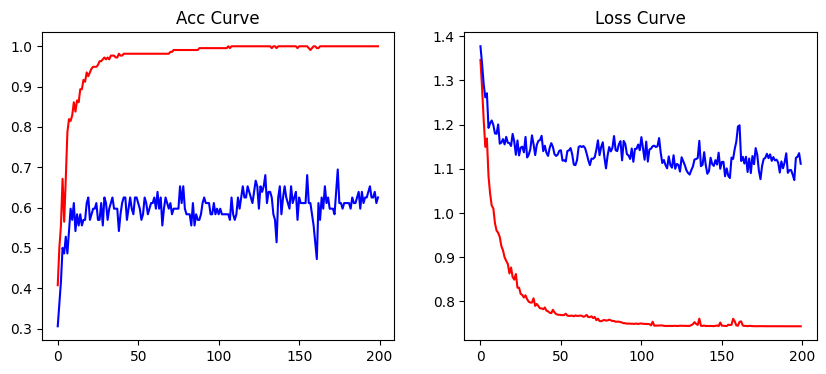

In [14]:
# Acc curve, Loss curve
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc Curve")
plt.plot(hist["acc"], color="red")
plt.plot(hist["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss Curve")
plt.plot(hist["loss"], color="red")
plt.plot(hist["val_loss"], color="blue")
plt.show()

### fine-tuning (SI+FT)

In [15]:
'''
### TODO: build the fine-tuning dataloader ###

# load pre-trained model
ep_num = 199 # TODO: the pre-trained epoch you want to tuning
model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", ep_num))
print(model_path)
checkpoint = torch.load(model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight


# Optional: lock pre-trained weight
# for param in model.parameters():
#     param.requires_grad = False

# load training data from original subject-independent training set
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

# simple train-valid split, only consider class balance (may not good enough), CAN be modified
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)

for c in range(4):
    x_, y_ = x_data[y_data == c], y_data[y_data == c]
    x_train = np.append(x_train, x_[:54], axis=0)
    y_train = np.append(y_train, y_[:54], axis=0)
    x_valid = np.append(x_valid, x_[54:], axis=0)
    y_valid = np.append(y_valid, y_[54:], axis=0)

# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

# fine-tuning training loop
for epoch in range(epochs):
    # training
    train_loss, train_acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)

    # validation
    val_loss, val_acc = evalate_an_epoch(model, val_loader, loss_fn)

    # print progress
    print("Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}".format(
        epoch + 1, epochs, train_loss, train_acc, val_loss, val_acc))

    # save model checkpoint
    torch.save({"state_dict": model.state_dict()}, os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", epoch + 1)))

'''

'\n### TODO: build the fine-tuning dataloader ###\n\n# load pre-trained model\nep_num = 199 # TODO: the pre-trained epoch you want to tuning\nmodel_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", ep_num))\nprint(model_path)\ncheckpoint = torch.load(model_path, map_location="cpu")  # load .pth\nmodel.load_state_dict(checkpoint["state_dict"])  # set model weight\n\n\n# Optional: lock pre-trained weight\n# for param in model.parameters():\n#     param.requires_grad = False\n\n# load training data from original subject-independent training set\nmat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))\nx_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()\n\n# simple train-valid split, only consider class balance (may not good enough), CAN be modified\nx_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)\ny_train = np.zeros((0, ), dtype=y_data.dtype)\nx_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)\ny_valid = np.zeros((0

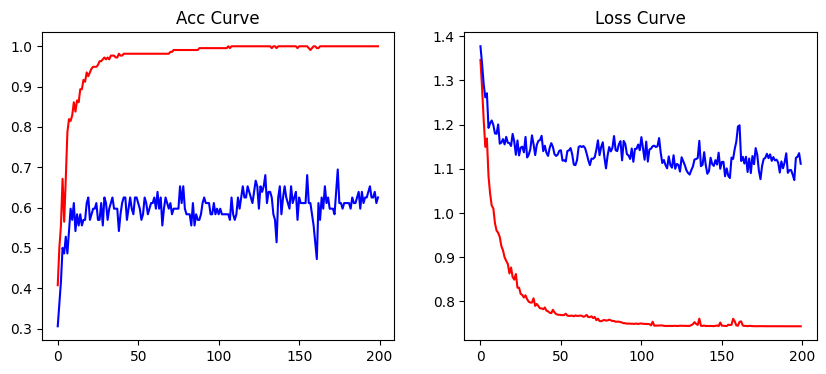

In [16]:
# plot for SI+FT
# Acc curve, Loss curve
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc Curve")
plt.plot(hist["acc"], color="red")
plt.plot(hist["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss Curve")
plt.plot(hist["loss"], color="red")
plt.plot(hist["val_loss"], color="blue")
plt.show()

## Test

In [17]:
# load pre-trained model
best_epoch = 199 # TODO: determine the `BEST` epoch
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# testing on subject S01 test (E) session
mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S01_E.mat"))
x, y = mat["x_test"], mat["y_test"].squeeze()
x = torch.from_numpy(x)
y = torch.from_numpy(y).long()
x = x.unsqueeze(1)
y = F.one_hot(y, 4)

print("test: {}, {}".format(x.size(), y.size()))

testset = torch.utils.data.TensorDataset(x, y)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
evalate_an_epoch(model, test_loader, loss_fn)


test: torch.Size([288, 1, 22, 562]), torch.Size([288, 4])


<ipython-input-8-86e85304a669>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)


(1.031736022896237, 0.7118055555555556)

## Analyzing
You need to do some further analysis including
- confusion matrix, 
- topographic maps for spatial kernel weights in SCCNet

You need to do these on your own in this section

In [18]:
# mne doc: https://mne.tools/stable/python_reference.html
# "data_detail.json" in BCI_hw3_dataset/ provides you with all channel names in this dataset. It will help you to plot a topoplot.


<ipython-input-8-86e85304a669>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)


Testing accuracy: 0.7118


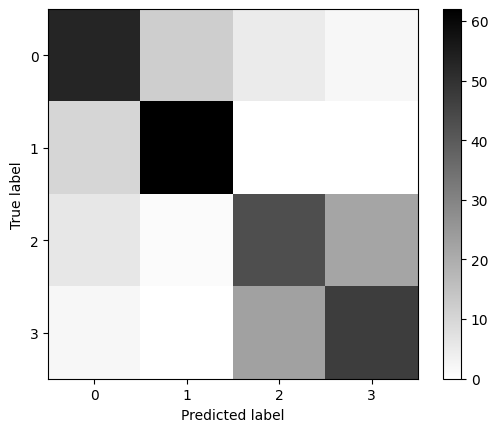

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# load the test data
mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S01_E.mat"))
x = torch.from_numpy(mat["x_test"])
y = torch.from_numpy(mat["y_test"]).squeeze()

# set the model to evaluation mode
model.eval()

# get the predicted labels for the test data
with torch.no_grad():
    x = x.unsqueeze(1).to(device, dtype=torch.float)
    out = model(x)
    y_pred = out.argmax(dim=1).detach().cpu().numpy()

# calculate the testing accuracy
test_acc = accuracy_score(y, y_pred)
print(f"Testing accuracy: {test_acc:.4f}")

# plot the confusion matrix
cm = confusion_matrix(y, y_pred)
plt.imshow(cm, cmap='binary', interpolation='None')
plt.colorbar()
plt.xticks([0, 1, 2, 3])
plt.yticks([0, 1, 2, 3])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


torch.Size([22, 1, 22, 1])


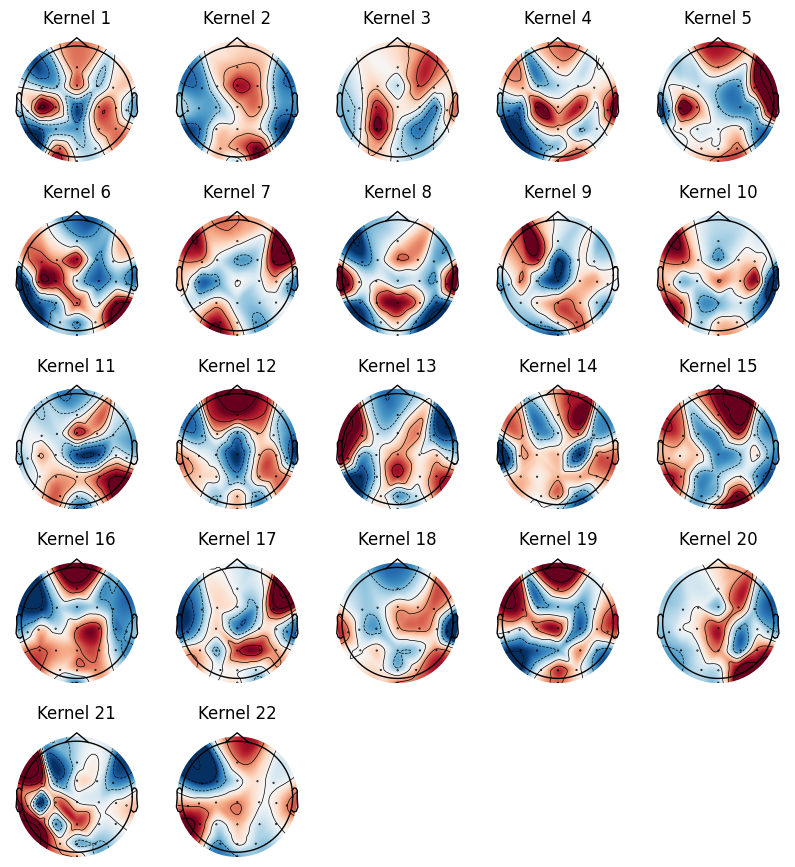

In [21]:
eegmodel = SCCNet # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict(fs=125.0, dropoutRate=0.5) # custom args for different EEG model
model = eegmodel(22, 562, 4, **kwargs)
best_epoch = 199
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu") 
model.load_state_dict(checkpoint["state_dict"])
first_weight = None
for p in model.parameters():
  print(p.shape)
  first_weight = p
  break


# Get electrode position form json
data_detail={"electrode": ["Fz", "FC3", "FC1", "FCz", "FC2", "FC4", "T7", "C3", "C1", "Cz", "C2", "C4", "T8", "CP3", "CP1", "CPz", "CP2", "CP4", "P1", "Pz", "P2", "POz"], "sample_freq": 125.0, "class-0": "left hand", "class-1": "right hand", "class-2": "feet", "class-3": "tongue"}
ch_names = data_detail["electrode"]
montage = mne.channels.make_standard_montage("standard_1020")
ch_indices = [montage.ch_names.index(ch_name) for ch_name in ch_names]
montage = mne.channels.make_standard_montage("standard_1020")

ch_pos =list(montage.get_positions()['ch_pos'].values())
a = np.array([ch_pos[i][0:2] for i in ch_indices])

# Plot 22 images
fig = plt.figure(figsize=(10, 10))
for i in range(22):
  ax = fig.add_subplot(5, 5, i+1)
  img, con = mne.viz.plot_topomap(first_weight[i].view(-1).detach().numpy(), a, axes=ax, show=False)
  #Add label and prediction to the title
  title = ""
  ax.set_title(f"Kernel {i+1}")
  #remove label of x and y axis
  ax.xaxis.set_tick_params(labelbottom=False)
  ax.yaxis.set_tick_params(labelleft=False)

## Generate Submission csv File

In [22]:
eegmodel = SCCNet # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict(fs=125.0, dropoutRate=0.5) # custom args for different EEG model
model = eegmodel(22, 562, 4, **kwargs)
best_epoch = hist["val_loss"].argmin()
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu") 
model.load_state_dict(checkpoint["state_dict"])

model.eval()
fd = open("SCCNet_ind.csv", "w")
csv_writer = csv.writer(fd)
csv_writer.writerow(["id", "Category"])
for sid in ["05", "06", "0A", "0B", "0C"]:
    mat = loadmat(os.path.join(DATASET_DIR_EXAM, f"BCIC_S{sid}_E.mat"))
    x = torch.from_numpy(mat["x_test"])
    x = x.unsqueeze(1).to(device, dtype=torch.float)
    p = model(x).argmax(dim=1).detach().cpu().numpy()
    for epoch_id, label in enumerate(p):
        csv_writer.writerow([f"S{sid}_{epoch_id}", label])
fd.close()

<ipython-input-8-86e85304a669>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)
